# Analyzing Computer Science versus Business Management Introductory Course Professors Reviews and Their Trends Over Time

William Ingold, Erik Kelemen, Ashish Manda

## Introduction

This project conducts a comprehensive analysis of the perceptions, grades, and reviews of computer science and business management undergraduate students at the University of Maryland, College Park. To achieve these means, we applied various data scraping, data cleaning, machine learning, and data visualization and analysis techniques we learned throughout the semester, and hope to demonstrate a deep understanding of the data science lifecycle. We also employed natural language processing and statistical analysis where suitable. We will illustrate the major trends in student perception of core classes and professors (how favorable certain professors are, or how hard a class may be), and we will draw generalized conclusions about the trends we observe over time (is a major getting easier? more likable?). 

### Motivation

###This project was sparked by interest in a question that all undergraduate students, at one point or another, face: How do my peers experience the core courses that all prospective students in my major are required to take? We hope that, by aggregating and conducting analysis of reviews and data available on major course-review websites such as PlanetTerp and RateMyProfessor, we would be able to grasp a data informed perspective to answer this question. Erik, one of the group members, is also a dual degree undergraduate student, enrolled in both the Computer Science and Business schools at UMD, and was interested in comparing student perceptions between these two majors.

## Setup

In [1]:
# Querying and requests of pages
import requests

# Parsing and handling HTML elements
from bs4 import BeautifulSoup

# Storage and manipulation of data
import pandas as pd
import numpy as np

# Used to check for the existance of files
from os import path

# Utilities
from itertools import chain
import collections
import re
import uuid

# Database and data storage
import pickle
import csv
import sqlite3
from sqlite3 import Error

# Selenium lets us load pages more natively, and can interact with the page
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

# For handling the time & dates for reviews
import time
import datetime

# Handling errors in try blocks
import traceback

# Graphs and Visualization
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# TODO: Keep NLTK?
# NlTK Libraries
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

## Only need to be run once
# nltk.download('stopwords')
# nltk.download('wordnet')

# SpaCy
## If using conda, do conda install -c conda-forge spacy
import spacy
import string # for punctuation list

# For ML 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

# Determine if we should utilize data storage
should_store_data = True

ModuleNotFoundError: No module named 'selenium'

## Data Storage: Setup Databases to Hold Review Data

TODO: Explain section

### Data Storage Part 1: Generic Database Functionality

In [ ]:
# Setup database presets
db_filepath = './data/db/'
bmgt_rmp_db_filepath = db_filepath + 'bmgt_rmp.db'
cmsc_rmp_db_filepath = db_filepath + 'cmsc_rmp.db'

bmgt_pt_db_filepath = db_filepath + 'bmgt_pt.db'
cmsc_pt_db_filepath = db_filepath + 'cmsc_pt.db'

In [ ]:
def create_connection(db_file):
    """Create a connection to the provided database file.
    
    Args:
        db_file: A string holding the filepath to a database.
    """
    
    conn = None
    
    if should_store_data:
        try:
            conn = sqlite3.connect(db_file)
            return conn
        except Error as e:
            print(e)

    return conn


def execute_create_command(conn, sql_command, params=()):
    """Executes the provided sql_command on the provided database.
    
    Args:
        conn: The connection object to the database.
        sql_command: A string containing the SQL command.
        params: A tuple of potential parameters.
    """
    
    try:
        c = conn.cursor()
        c.execute(sql_command, params)
        
    except Error as e:
        print(e)
    
    
def execute_insert_command(conn, table_name, column_list, params=()):
    """Executes the provided sql_command on the provided database.
    
    Args:
        conn: The connection object to the database.
        sql_command: A string containing the SQL command.
        params: A tuple of potential parameters.
    """
    
    # Question mark for each value to be filled, don't want a trailing comma
    question_marks = "?," * (len(column_list) - 1)
    question_marks = question_marks + "?"
    
    column_names = ",".join(column_list)
    
    insert_sql = """INSERT INTO {table_name} (
                                {column_names}
                           )
                           VALUES({question_marks})
                           """.format(table_name=table_name, 
                                      question_marks=question_marks,
                                      column_names=column_names)
    
    try:
        c = conn.cursor()
        c.execute(insert_sql, params)
        conn.commit()
        
        return c.lastrowid
    except Error as e:
        print(e)
        
        
def execute_query_command(conn, sql_command, params=()):
    """Executes the provided sql_command on the provided database.
    
    Args:
        conn: The connection object to the database.
        sql_command: A string containing the SQL command.
        params: A tuple of potential parameters.
    """
    
    try:
        c = conn.cursor()
        c.execute(sql_command, params)
        
        return c.fetchall()
    
    except Error as e:
        print(e)
        

def is_professor_scraped(db_conn, professor_name):
    """Returns if the professor's RateMyProfessors page has been scraped already.
    
    Args:
        db_conn: Connection object to the appropriate database.
        professor_name: String holding the professor's name.
    """
    
    if should_store_data:
        sql_command = """SELECT
                            full_name
                        FROM
                            professor_stats ps
                        WHERE
                            full_name LIKE ?"""

        params=('%'+professor_name+'%',)

        result = execute_query_command(db_conn, sql_command, params)

        return len(result) != 0
    else:
        return False


def insert_dataframe_into_db(db_conn, df, table_name, column_headers=None):
    """Inserts all rows of a given dataframe to the database's table.
    
    Args:
        db_conn: Connection object to a database.
        df: Pandas DataFrame object containing data to insert.
        table_name: String holding a table name to insert into ('reviews' or 'professor_stats')
    """
    
    if should_store_data:
        if column_headers is None:
            column_list = list(df.columns)
        else:
            column_list = column_headers

        for idx, row in df.iterrows():
            execute_insert_command(db_conn, table_name, column_list, tuple(row.array))


def get_professor_stats_from_db(db_conn, professor):
    """Reads the professor_stats table into a pandas dataframe and returns it."""
    
    sql_query = """SELECT * FROM professor_stats WHERE full_name LIKE ?"""
    
    return pd.read_sql_query(sql_query, db_conn, params=[professor])

def get_professor_reviews_from_db(db_conn, professor):
    """Reads the reviews table into a pandas dataframe and returns it."""
    
    sql_query = """SELECT * FROM reviews WHERE full_name LIKE ?"""
    
    return pd.read_sql_query(sql_query, db_conn, params=[professor])

def get_course_grades_from_db(db_conn, course):
    """Reads the grades table for a certain course into a pandas data
    frame and returns it."""
    
    if should_store_data:
        sql_query = """SELECT * FROM grades WHERE course LIKE ?"""

        return pd.read_sql_query(sql_query, db_conn, params=[course])
    else:
        return pd.DataFrame()
    
    
def insert_review_sentiment(db_conn, review_id, sentiment_score, sentiment_label):
    if should_store_data:
        update_sql = """UPDATE reviews
                            SET sentiment_score = ?,
                                sentiment_ground_label = ?
                        WHERE review_id LIKE ?"""

        try:
            c = db_conn.cursor()
            c.execute(update_sql, (sentiment_score, sentiment_label, review_id))
            db_conn.commit()

        except Error as e:
            print(e)
        
    
def insert_all_review_sentiment_labels(db_conn, review_sentiment_df):
    if should_store_data:
        for row in review_sentiment_df.itertuples():
            insert_review_sentiment(db_conn, row.review_id, row.sentiment_score, row.sentiment_ground_label)

def get_review_sentiment(db_conn, review_id):
    sql_command = """SELECT sentiment_score FROM reviews WHERE review_id LIKE ?"""
    
    result = execute_query_command(db_conn, sql_command, (review_id,))
    
    if len(result) == 0:
        return np.nan
    else:
        return result[0]

### Data Storage Part 2: RateMyProfessor Specific Database Functionality

In [ ]:
def create_rmp_tables(rmp_conn):
    """Create the stats and review tables for RateMyProfessors data.
    
    Args:
        rmp_conn: Connection object to a RateMyProfessors database.
    """
    
    stats_table = """ CREATE TABLE IF NOT EXISTS professor_stats (
                        id INTEGER PRIMARY KEY,
                        first_name TEXT NOT NULL,
                        last_name TEXT NOT NULL,
                        full_name TEXT NOT NULL UNIQUE ON CONFLICT IGNORE,
                        page_exists INTEGER NOT NULL,
                        rating REAL,
                        take_again REAL,
                        difficulty REAL,
                        rating_count INTEGER
                    ) """
    
    review_table = """ CREATE TABLE IF NOT EXISTS reviews (
                        id INTEGER PRIMARY KEY,
                        review_id TEXT NOT NULL UNIQUE ON CONFLICT IGNORE,
                        full_name TEXT NOT NULL,
                        course TEXT NOT NULL,
                        date INTEGER NOT NULL,
                        body TEXT NOT NULL,
                        thumb_up INTEGER,
                        thumb_down INTEGER,
                        rating REAL NOT NULL,
                        difficulty REAL NOT NULL,
                        sentiment_score REAL,
                        sentiment_ground_label INTEGER
                   ) """
    
    review_tags_table = """CREATE TABLE IF NOT EXISTS review_tags (
                            id INTEGER PRIMARY KEY,
                            review_id TEXT NOT NULL,
                            tag_name TEXT NOT NULL
                        )"""
    
    review_meta_table = """CREATE TABLE IF NOT EXISTS meta_tags (
                            id INTEGER PRIMARY KEY,
                            review_id TEXT NOT NULL,
                            meta_name TEXT NOT NULL,
                            value TEXT NOT NULL
                        )"""
    
    professor_tags_table = """CREATE TABLE IF NOT EXISTS professor_tags (
                                id INTEGER PRIMARY KEY,
                                full_name TEXT NOT NULL,
                                tag_name
                        )"""
    
    execute_create_command(rmp_conn, stats_table)
    execute_create_command(rmp_conn, review_table)
    execute_create_command(rmp_conn, review_tags_table)
    execute_create_command(rmp_conn, review_meta_table)
    execute_create_command(rmp_conn, professor_tags_table)

    
def get_rmp_review_grade(rmp_conn, review_id):
    sql_query = """SELECT value, review_id FROM meta_tags WHERE review_id LIKE ? AND meta_name LIKE '%Grade%'"""
    
    return pd.read_sql_query(sql_query, rmp_conn, params=[review_id])


def get_rmp_review_tags(rmp_conn, review_id):
    sql_query = """SELECT review_id, tag_name FROM review_tags WHERE review_id LIKE ?"""
    
    return pd.read_sql_query(sql_query, rmp_conn, params=[review_id])


def get_rmp_review_all_meta(rmp_conn, review_id):
    sql_query = """SELECT review_id, meta_name, value FROM meta_tags WHERE review_id LIKE ?"""
    
    return pd.read_sql_query(sql_query, rmp_conn, params=[review_id])


def get_rmp_data_for_all_ids(rmp_filepath, review_df, query_func):
    """Given a DataFrame full of review_ids, query the database for the requested data
    for each review_id and create a dataframe full of the data. This will be easier to
    merge with other review dataframes, since they'll have matching review_ids.
    
    Args:
        rmp_filepath: String holding the filepath to the RMP database.
        review_df: A pandas dataframe that should hold review_ids
        query_func: A RMP database query function, i.e. get_rmp_review_grade,
            get_rmp_review_tags, get_rmp_all_meta
            
    Returns:
        A dataframe with at least a review_id column and columns of requested data.
    """
    
    rmp_conn = create_connection(rmp_filepath)
    data_df = pd.DataFrame()
    
    try:
        data = review_df['review_id'].apply(lambda review_id: query_func(rmp_conn, review_id)).tolist()
        data_df = pd.concat(data)
    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()
    finally:
        rmp_conn.close()
        
    return data_df 


def get_rmp_prof_tags(rmp_conn, full_name):
    sql_query = """SELECT tag_name FROM professor_tags WHERE full_name LIKE ?"""
    
    return pd.read_sql_query(sql_query, rmp_conn, params=[full_name])

In [ ]:
if should_store_data:
    # Create the CMSC and BMGT database with the two tables
    cmsc_rmp_db = create_connection(cmsc_rmp_db_filepath)
    bmgt_rmp_db = create_connection(bmgt_rmp_db_filepath)

    create_rmp_tables(cmsc_rmp_db)
    create_rmp_tables(bmgt_rmp_db)

    # Close for now, will reopen when writing to them
    cmsc_rmp_db.close()
    bmgt_rmp_db.close()

### Data Storage Part 3: PlanetTerp Database Functionality

In [ ]:
def create_pt_tables(pt_conn):
    """Create the stats and review tables for RateMyProfessors data.
    
    Args:
        pt_conn: Connection object to a PlanetTerp database.
    """
    
    # TODO: Keep track of grade distribution in this table?
    stats_table = """ CREATE TABLE IF NOT EXISTS professor_stats (
                        id INTEGER PRIMARY KEY,
                        first_name TEXT NOT NULL,
                        last_name TEXT NOT NULL,
                        full_name TEXT NOT NULL UNIQUE ON CONFLICT IGNORE,
                        page_exists INTEGER NOT NULL,
                        slug TEXT,
                        review_count INTEGER NOT NULL,
                        rating REAL,
                        type TEXT
                    ) """
    
    # TODO: Review id format? <professor last name>-<#> ?
    review_table = """ CREATE TABLE IF NOT EXISTS reviews (
                        id INTEGER PRIMARY KEY,
                        review_id TEXT NOT NULL UNIQUE ON CONFLICT IGNORE,
                        full_name TEXT NOT NULL,
                        course TEXT NOT NULL,
                        date INTEGER NOT NULL,
                        body TEXT NOT NULL,
                        rating INTEGER NOT NULL,
                        expected_grade TEXT,
                        sentiment_score REAL,
                        sentiment_ground_label INTEGER
                   ) """
    
    grades_table = """ CREATE TABLE IF NOT EXISTS grades (
                            id INTEGER PRIMARY KEY,
                            course TEXT NOT NULL,
                            semester INTEGER,
                            grade TEXT,
                            count INTEGER NOT NULL
                    )"""
    
    execute_create_command(pt_conn, stats_table)
    execute_create_command(pt_conn, review_table)
    execute_create_command(pt_conn, grades_table)

In [ ]:
if should_store_data:
    # Create the CMSC and BMGT database with the two tables
    cmsc_pt_db = create_connection(cmsc_pt_db_filepath)
    bmgt_pt_db = create_connection(bmgt_pt_db_filepath)

    create_pt_tables(cmsc_pt_db)
    create_pt_tables(bmgt_pt_db)

    # Close for now, will reopen when writing to them
    cmsc_pt_db.close()
    bmgt_pt_db.close()

### End Data Storage

TODO: Accomplished section

## Data Collection Part 1: Grabbing Introductory Course Professors From UMD.io

TODO: Explain section

In [ ]:
# Base API url for UMD.io
professors_url = "https://api.umd.io/v1/professors"

# Base API url for PlanetTerp
pt_courses_url = "https://api.planetterp.com/v1/course"

# The filepaths for the files to hold professor information
cmsc_professor_names_filepath = './data/cmsc_professor_names.csv'
bmgt_professor_names_filepath = './data/bmgt_professor_names.csv'

# Determines if we've created these already
have_cmsc_professors = path.exists(cmsc_professor_names_filepath)
have_bmgt_professors = path.exists(bmgt_professor_names_filepath)


# Courses we're interseted in look at
# TODO: What about honors?
# TODO: Dr. Eastman has taught CMSC131, per RateMyProfessor, but wasn't given via UMD.IO
cmsc_course_ids = ["CMSC131", "CMSC132", "CMSC216", "CMSC250"]
bmgt_course_ids = ["BMGT110", "BMGT220", "BMGT221", "BMGT230"]

#### Utilities for saving professor data to a file

In [ ]:
def read_professor_name_data(professor_filepath):
    """Reads the professor names and their courses from a CSV file.
    
    Args:
        professor_filepath: String holding a filepath to the professor csv file.
        
    Returns:
        A dictionary of professor names to a set of courses they have taught.
    """
    
    with open(professor_filepath, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0

        professors = {}

        for row in csv_reader:
            if line_count != 0:
                professors[row['name']] = set([course for course in row['courses'].split(' ')])
            line_count += 1

        return professors

def save_professor_data(professors, filepath):
    """Saves the professor names and their courses to a CSV file.
    
    Args:
        professors: A dictionary of professor name keys and a set of courses for values.
    """
    
    columns = ['name', 'courses']
    try:
        with open(filepath, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=columns)
            writer.writeheader()
            
            for name, courses in professors.items():
                writer.writerow({'name': name, 'courses': ' '.join(courses)})
                
    except IOError:
        print("Error in writing the CSV file")

#### Utility to actually grab professors based on a list of courses

In [ ]:
def get_professors_for_courses_from_umdio(course_ids):
    """Gets all the professors for the given course_ids from UMD.io 
    and returns a dictionary of professor to courses.
    
    Args:
        course_ids: A list of course ids (e.g. ['CMSC216', CMSC250']).
        
    Returns:
        Dictionary of professor to set of courses.
    
    """
    
    professors = {}
    
    for course_id in course_ids:
        params = {'course_id': course_id}

        response = requests.get(professors_url, params)
        
        if response.status_code == 200:

            for item in response.json():
                name = item['name']

                if name in professors:
                    professors[name].add(course_id)
                else:
                    professors[name] = {course_id}

    return professors


def get_professors_for_courses_from_pt(course_ids):
    """Gets all the professors for the given course_ids from PlanetTerp
    and returns a dictionary of professor to courses.
    
    Args:
        course_ids: A list of course ids (e.g. ['CMSC216', CMSC250']).
        
    Returns:
        Dictionary of professor to set of courses.
    
    """
    
    professor_list = {}
    
    for course_id in course_ids:
        params = {'name': course_id}

        response = requests.get(pt_courses_url, params)
        
        if response.status_code == 200:
            professors = response.json().get('professors', None)
            
            if professors:
                for professor in professors:
                    if professor in professor_list:
                        professor_list[professor].add(course_id)
                    else:
                        professor_list[professor] = {course_id}

    return professor_list

def combine_professor_dictionaries(dict_one, dict_two):
    combined_profs = collections.defaultdict(set)

    for key, val in chain(dict_one.items(), dict_two.items()):
        combined_profs[key] = combined_profs[key].union(val)
        
    return combined_profs

def get_all_professors_from_courses(course_ids):
    umdio_professors = get_professors_for_courses_from_umdio(course_ids)
    pt_professors = get_professors_for_courses_from_pt(course_ids)
    
    return combine_professor_dictionaries(umdio_professors, pt_professors)
    


### Grab Computer Science Professors

In [ ]:
# Only query the UMD.io API if we don't have the data
if not have_cmsc_professors or not should_store_data:
    cmsc_professors = get_all_professors_from_courses(cmsc_course_ids)
    
    save_professor_data(cmsc_professors, cmsc_professor_names_filepath)
    have_cmsc_professors = True
else: 
    cmsc_professors = read_professor_name_data(cmsc_professor_names_filepath)

    if not cmsc_professors:
        print("Error response from umd.io API")

if 'Iason Filippou' in cmsc_professors:
    cmsc_professors.pop('Iason Filippou') # A typo of Jason Filippou from the database
    
print(cmsc_professors)

### Grab Business Management Professors

In [ ]:
# Only query the UMD.io API if we don't have the data
if not have_bmgt_professors or not should_store_data:
    bmgt_professors = get_all_professors_from_courses(bmgt_course_ids)
    
    save_professor_data(bmgt_professors, bmgt_professor_names_filepath)
    have_bmgt_professors = True
else:
    bmgt_professors = read_professor_name_data(bmgt_professor_names_filepath)

    if not bmgt_professors:
        print("Error response from umd.io API")

print(bmgt_professors)

## Data Collection Part 2: Grabbing Reviews From RateMyProfessors

TODO: Describe section

### Data Collection Part 2.1: Setup and Utilities to Scrape and Parse Data from RateMyProfessor

#### Data Collection Part 2.1.1: Setup Data

In [ ]:
# Data needed for requesting data from RateMyProfessor
ratemyprofessor_url = "https://www.ratemyprofessors.com/search.jsp"
params = {'queryoption':'HEADER', 'schoolID':'1270', 'queryBy':'teacherName', 'schoolName':'University+of+Maryland'}
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:82.0) Gecko/20100101 Firefox/82.0",
    "Access-Control-Allow-Origin": "*",
    "Access-Control-Allow-Headers": "Content-Type",
    "Access-Control-Allow-Methods": "GET",
}


# List of tags that RateMyProfessor uses to describe professors, which are used for the database and dataframes
tag_list = ['gives_good_feedback', 'respected', 'lots_of_homework', 'accessible_outside_class',
           'get_ready_to_read', 'participation_matters', 'inspirational',
           'graded_by_few_things', 'test_heavy', 'group_projects', 'clear_grading_criteria', 
           'hilarious', 'beware_of_pop_quizes', 'amazing_lectures', 'lecture_heavy', 'caring',
           'extra_credit', 'so_many_papers', 'tough_grader', 'skip_class_wont_pass']

# Want to tie the code friendly tag names to what is found on a RateMyProfessor page
text_tag_list = [' '.join(x.split('_')) for x in tag_list]
text_tag_list.remove('skip class wont pass')
text_tag_list.append("skip class? you won't pass.")

# both tag_list and text_tag_list in same order, and correspond to one another
text_tag_dict = {text_tag_list[i]: tag_list[i] for i in range(len(text_tag_list))}

# These are the column headers for a professor's overall statistics found at the top of the page
overall_header_list = ['first_name', 'last_name', 'full_name', 'page_exists', 'rating', 'take_again', 'difficulty',
                      'rating_count']

# Review post column headers. The meta list is the row of top meta responses (like 'Grade: A-').
review_meta_list = ['would_take_again', 'grade', 'textbook', 'online_class', 'for_credit', 'attendance']
review_text_meta_list = [' '.join(x.split('_')) for x in review_meta_list]
review_meta_dict = {review_text_meta_list[i]: review_meta_list[i] for i in range(len(review_meta_list))}
        
review_header_list = ['review_id', 'full_name', 'course', 'date', 'rating', 'difficulty', 'body',
                      'thumb_up', 'thumb_down']

#### Data Collection Part 2.1.2: Utility Functionality

In [ ]:
def tags_to_dict(provided_tags):
    """Turns the list of text tags (e.g. skip class? you won't pass) into a dictionary
    of approriately named tags that work for database columns and if they were present.
    
    Args:
        provided_tags: A list of space separated tags scraped from the RMP page.
        
    Returns:
        A dictionary of {tag: 1 or 0} on whether a tag was used to describe the professor.
    """
    
    tag_dict = {val: 0 for val in text_tag_dict.values()}
    
    for tag in provided_tags:
        if tag.lower() in text_tag_dict.keys():
            tag_dict[text_tag_dict[tag.lower()]] = 1
            
    return tag_dict

def meta_to_dict(provided_meta):
    """Turns the dictionary of meta tags (e.g. Would Take Again: No) into a dictionary
    of appropriately named tags that work for database columns and values if they were present.
    
    Args:
        provided_meta: A dictionary of meta information from a review.
        
    Returns:
        A dictionary of {meta: 1 or 0} on whether a meta was used on the review.
    """
    
    meta_dict = {val: 0 for val in review_meta_list}
    
    for meta, response in provided_meta.items():
        value = 0
        
        if meta.lower() in review_meta_dict.keys():
            
            if response.lower() == "yes" or response.lower() == "mandatory":
                value = 1
                
            if meta.lower() == "grade":
                value = response
            
            meta_dict[review_meta_dict[meta.lower()]] = value
            
    return meta_dict

### Data Collection Part 2.2: Querying RateMyProfessor and Getting the Professor's URL

In [ ]:
def find_rmp_professor_url(html_doc):
    """Finds the professor's URL on the search page and returns it.
    
    Args:
        html_doc: A string containing an HTML document.
        
    Returns:
        The full URL for the professor's page (if found).
    
    """
    
    soup = BeautifulSoup(html_doc, 'html.parser')
    main_url = "https://www.ratemyprofessors.com"
    prof_urls = []
    
    no_results = soup.find('div[class*="NoResultsFoundArea__StyledNoResultsFound"]')
    prof_list_items = soup.find_all('li', class_='listing PROFESSOR')
    
    # Sometimes RMP does the search differntly, so it'll be elsewhere
    diff_location = soup.find('a', attrs={'class': lambda x: 'TeacherCard__StyledTeacherCard' in x if x else False}, href=True)
    
    # The professor may not be reviewed
    if no_results is None and prof_list_items and len(prof_list_items) != 0:
        if diff_location:
            prof_urls.append(main_url + diff_location['href'])
        else:
            # Each should be from University of Maryland due to search params
            for item in prof_list_items: 
                partial_url = item.find('a', href=True)

                if partial_url:
                    prof_urls.append(main_url + partial_url['href'])
                        
                        
    return prof_urls
    
    
def query_rmp_for_professor_url(professor_name, headers, params):
    """Queries RateMyProfessor for the professor, given the parameters and headers.
    
    Args:
        professor_name: The <first name> <last name> of the professor.
        headers: Dictionary of headers for the get request.
        params: Dictionary of parameters for the get request.
        
    Returns:
        The full URL for the professor's page after searching for it (if found).
        
    """
    
    params['query'] = professor_name
    
    response = requests.get(ratemyprofessor_url, headers=headers, params=params)
    
    if response.status_code == 200:
        url = find_rmp_professor_url(response.text)
        
        if url is not None:
            return url
        else:
            print("Professor {name} has not been reviewed.".format(name=professor_name))
            return None

### Data Collection Part 2.3: Parsing the Professor Overall Information (Stats and Tags)

In [ ]:
def get_rmp_prof_stats(page_text):
    """Parses the professor's stats from their page and returns them. Namely their overall rating, 
    how many would take again, overall difficulty and how many ratings they have on RateMyProfessor.
    
    Args:
        page_text: An HTML document of the professor's page.
        
    Returns:
        A dictionary containing their rating, take again percentage, difficulty rating, and rating count.
    """
    
    soup = BeautifulSoup(page_text, 'html.parser')
    
    rating_score = soup.select('div[class*="RatingValue__Numerator"]')
    
    take_again = np.nan
    difficulty = np.nan
    
    if rating_score is not None and rating_score[0].text != 'N/A':
        rating_score = float(rating_score[0].text)
    else:
        rating_score = np.nan
    
    feedback_cont = soup.select('div[class*="TeacherFeedback__StyledTeacherFeedback"]') #[0].select('div[class*="FeedbackItem__FeedbackNumber"]')
    
    if feedback_cont and len(feedback_cont) > 0:
        feedback_nums = feedback_cont[0].select('div[class*="FeedbackItem__FeedbackNumber"]')
        
        if feedback_nums and len(feedback_nums) == 2:
            if len(feedback_nums[0].text) > 0:
                try:
                    take_again = float(feedback_nums[0].text[:-1]) / 100
                except ValueError:
                    take_again = np.nan
                
            if len(feedback_nums[1].text) > 0:
                try:
                    difficulty = float(feedback_nums[1].text)
                except ValueError:
                    difficulty = np.nan
    
    rating_count_int = 0
    rating_count_cont = soup.select('div[class*="RatingValue__NumRatings"]') #[0].select('a')[0].text
    
    
    if rating_count_cont and len(rating_count_cont) > 0:
        rating_count_a = rating_count_cont[0].select('a')
        
        if rating_count_a and len(rating_count_a) > 0:
            rating_count = rating_count_a[0].text
            
            try:
                rating_count_int = int(rating_count)
            except ValueError:
                rating_count_int = 0
            
        
    try:
        rating_count_int = int(''.join([x for x in rating_count if x.isdigit()]))
    except ValueError:
        rating_count_int = 0
        
    stats_dict = {'rating': rating_score, 'take_again': take_again, 'difficulty': difficulty, 'rating_count': rating_count_int}
    return stats_dict


def get_rmp_prof_top_tags(page_text, prof_name, rmp_conn):
    """Parses and returns the professor's top tags.
    
    Args:
        page_text: An HTML document of the professor's page.
        
    Returns:
        A list of tags describing the professor.
    """
    
    soup = BeautifulSoup(page_text, 'html.parser')
    
    tags_df = pd.DataFrame(columns=['full_name', 'tag_name'])
    
    unparsed_tags = soup.select('div[class*="TeacherTags__TagsContainer"]')
    
    if unparsed_tags and len(unparsed_tags) != 0:
        unparsed_tags = unparsed_tags[0].select('span')
    
        for tag in unparsed_tags:
            tags_df = tags_df.append({'full_name': prof_name, 'tag_name': tag.text}, ignore_index=True)
        
    insert_dataframe_into_db(rmp_conn, tags_df, 'professor_tags')


def rmp_prof_overall_to_dataframe(professor_name, stats, page_exists=1):
    """Combines the professor's overall stats and tags into a pandas dataframe.
    
    Args:
        professor_name: String holding the professor's name.
        stats: A dictionary holding the overall stats (e.g. 'would_take_again': .83).
        tags: A dictionary holding the tags associated with a professor (e.g. {'caring': 1}).
        page_exists (optional, default=1): Integer boolean determining if a professor has a RMP page.
        
    Returns:
        A dataframe containing the combination of professor name, stats, and tags.
    """
    
    overall_df = pd.DataFrame(columns=overall_header_list)
    
    first_name, last_name = professor_name.split(' ', 1)
    overall_dict = {'first_name': first_name, 'last_name': last_name, 'full_name': professor_name, 'page_exists': page_exists}
    
    overall_dict.update(stats)
    
    overall_df = overall_df.append(overall_dict, ignore_index=True)
    
    return overall_df

### Data Collection Part 2.4: Use Selenium to Load All Professor Reviews

In [ ]:
def start_selenium():
    """Starts up the Selenium browser."""
    driver = webdriver.Firefox(executable_path='./bin/geckodriver.exe')
    return driver
    
def stop_selenium(driver):
    """Shutdown the Selenium browser."""
    driver.close()
    driver.quit()
    
def load_all_rmp_reviews(page_url, driver):
    """Loads all the reviews for a given porfessor and returns the text of all of them.
    
    Args:
        page_url: The URL for the professor's page.
        
    Returns:
        A string containing the HTML for all the reviews.
    """

    driver.get(page_url)
    
    # RateMyProfessors has a cookies pop up that overlays the website, it needs to be closed first
    time.sleep(1)
    close_cookies = driver.find_elements(By.XPATH, '//button[text()="Close"]')
    
    if close_cookies:
        close_cookies[0].click()
        
    load_more = driver.find_elements(By.XPATH, '//button[text()="Load More Ratings"]')
    
    # RateMyProfessors paginates the reviews via Javascript, so we must continually load more while the button is present
    while load_more:
        load_more[0].click()
        time.sleep(1)
        load_more = driver.find_elements(By.XPATH, '//button[text()="Load More Ratings"]')
        
        
    try:
        all_reviews = driver.find_element_by_id('ratingsList').get_attribute('outerHTML')
    except NoSuchElementException:
        all_reviews = ''
    
    
    return all_reviews

### Data Collection Part 2.5: Parsing Utilities for a Single Review

In [ ]:
def string_date_to_unix(date_str):
    """Turns the RateMyProfessor date format (e.g. Nov 23rd, 2020) into a
    UTC timestamp. Assumes the date is already in UTC.
    
    Args:
        date_str: A string containing the RateMyProfessor review date.
        
    Returns:
        A UTC timestamp corresponding to the date provided.
    """
    
    # Split into month, day, year
    date_split = date_str.split(' ')
    day = date_split[1]
    
    # Remove comma and suffix for day
    day = day[:-3]
    
    # Place the day back into the list and join everything back together
    date_split[1] = day
    remade_date_str = (' ').join(date_split)
    
    # Change into UTC time
    datetime_obj = datetime.datetime.strptime(remade_date_str, '%b %d %Y')
    utc_time = datetime_obj.timestamp()
    
    return utc_time
    
def parse_rating_header(soup):
    """Parses and returns the rating header for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A dictionary containing the course and date for the review.
    """
    
    rating_header = soup.select('div[class*="Rating__RatingInfo"]')
    
    if len(rating_header) != 0:
        course = rating_header[0].select('div[class*="RatingHeader__StyledClass"]')[0].text.strip()
        date = rating_header[0].select('div[class*="TimeStamp__StyledTimeStamp"]')[0].text.strip()
        
        utc_time = string_date_to_unix(date)
    else:
        print(soup)
    
    return {'course': course, 'date': utc_time}

def parse_meta_data(soup, review_id, rmp_conn):
    """Parses and returns the meta data for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A dictionary containing the meta data (e.g. Would Take Again) for the review.
    """
    
    course_meta = soup.select('div[class*="CourseMeta__StyledCourseMeta"]')[0]
    review_meta_data = {}
    
    meta_tag_df = pd.DataFrame(columns=['review_id', 'meta_name', 'value'])

    for meta_div in course_meta.select('div'):
        meta_data = meta_div.text.split(':')
        meta_name = meta_data[0].strip()
        meta_value = meta_data[1].strip()

        meta_tag_df = meta_tag_df.append({'review_id': review_id, 'meta_name': meta_name, 'value': meta_value}, ignore_index=True)
        
        
    insert_dataframe_into_db(rmp_conn, meta_tag_df, 'meta_tags')


def parse_rating_data(soup):
    """Parses and returns the rating data for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A dictionary containing the rating data for the quality and difficulty for the review.
    """
    
    rating_values_text = soup.select('div[class*="RatingValues__StyledRatingValues"]')[0].select('div[class*="RatingValues__RatingValue"]')
    quality = rating_values_text[0].text
    difficulty = rating_values_text[1].text

    rating_data = {'rating': quality, 'difficulty': difficulty}
    
    return rating_data

def parse_review_tags(soup, review_id, rmp_conn):
    """Parses and returns the tags for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A list containing the tags for the review.
    """
    
    tag_container = soup.select('div[class*="RatingTags__StyledTags"]')
    
    review_tags_df = pd.DataFrame(columns=['review_id', 'tag_name'])
    
    if tag_container: # Since not all reviews add tags
        unparsed_tags = tag_container[0].select('span')

        for tag in unparsed_tags:
            review_tags_df = review_tags_df.append({'review_id': review_id, 'tag_name': tag.text}, ignore_index=True)

    insert_dataframe_into_db(rmp_conn, review_tags_df, 'review_tags')
    
def parse_thumb_scoring(soup):
    """Parses and returns the thumb scoring data for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A dictionary containing the thumb scoring data for the review.
    """
    
    thumb_container = soup.select('div[class*="RatingFooter__StyledRatingFooter"]')[0].select('div[class*="RatingFooter__HelpTotal"]')

    thumb_up = int(thumb_container[0].text.strip())
    thumb_down = int(thumb_container[1].text.strip())
    thumb_data = {'thumb_up': thumb_up, 'thumb_down': thumb_down}

    return thumb_data

def parse_review_text(soup):
    """Parses and returns the review body text for a single review.
    
    Args:
        soup: An initialized BeautifulSoup object for the professor's page.
        
    Returns:
        A string containing the review text for the review.
    """
    
    review_text = soup.select('div[class*="Comments__StyledComments"]')[0].text
    
    return {'body': review_text}
    
def parse_single_rmp_review(rmp_url, review_item, courses, rmp_conn):
    """Parses and returns all data for a single review.
    Namely it returns: Meta data, rating data, tags, thumb_scoring, and review text.
    
    Args:
        review_item: A single review list item containing all the appropraite HTML.
        
    Returns:
        A dictionary containing the meta data, rating data, tags, thumb_scoring, and review text
        for a single review.
    """
    
    soup = BeautifulSoup(review_item, 'html.parser')
    
    course_and_date = parse_rating_header(soup)
    
    # TODO: Loses course reviews like 'CMSC131CMSC132' where students combined multiple courses they took
    if course_and_date['course'] in courses:
        
        # Rating data
        rating_data = parse_rating_data(soup)
        
        # Thumb Scoring
        thumb_scoring = parse_thumb_scoring(soup)
        
        # Review body
        review_text = parse_review_text(soup)
        
        # Generate a UUID for the review using the review's text - IMPORTANT FOR FINDING AGAIN
        review_id = uuid.uuid5(uuid.NAMESPACE_URL, rmp_url + review_text['body'])
        review_id_str = str(review_id)
        
        # Meta data - Stored in own table in the database
        meta_data = parse_meta_data(soup, review_id_str, rmp_conn)
        
        # Tags - Stored in own table in the database
        parse_review_tags(soup, review_id_str, rmp_conn)
        
        return {'review_id_data': {'review_id': review_id_str}, 'rating_data': rating_data, 'thumb_scoring': thumb_scoring,
                'review_text': review_text, 'rating_header': course_and_date}

### Data Collection 2.6: Parsing Utilities for an Entire RateMyProfessor Page

In [ ]:
def get_rmp_prof_reviews(rmp_prof_url, selenium_driver, rmp_conn, prof_name, courses):
    """Gets all the RateMyProfessor reviews for a given professor and places into a
    dataframe. Only grabs reviews for classes in the provided courses.
    
    Args:
        rmp_prof_url: A string containing the RateMyProfessor URL for the professor.
        prof_name: A string containing the professor's name.
        prof_courses: List of courses to look for in the reviews.
        
    Returns:
        A dataframe containing all the appropriate reviews.
    """
    
    reviews_html = load_all_rmp_reviews(rmp_prof_url, selenium_driver)
    soup = BeautifulSoup(reviews_html, 'html.parser')
    
    first_name, last_name = prof_name.split(' ', 1)
    
    review_df = pd.DataFrame(columns=review_header_list)
    
    for review in soup.find_all('li'):
        
        if len(review.select('div[class*="Rating__StyledRating"]')) != 0: # Avoid advertisement list items
            data = parse_single_rmp_review(rmp_prof_url, str(review), courses, rmp_conn)

            if data: # Since the review could be of an undesired course
                flattened_data = {'full_name': prof_name}

                for data_type, data_dict in data.items():
                    
                    for key, val in data_dict.items():
                        flattened_data[key] = val

                review_df = review_df.append(flattened_data, ignore_index=True)
    
    return review_df


def parse_rmp_page(rmp_prof_url, headers, rmp_conn, selenium_driver, professor_name, courses):
    """Parses an entire RateMyProfessor professor page for overall stats & tags, and all
    of their reviews. It will return two dataframes holding this information and insert
    them into a database.
    
    Args:
        rmp_prof_url: A string containing the RateMyProfessor URL for the professor.
        headers: Request headers to use.
        rmp_conn: Connection object to the RateMyProfessor database.
        prof_name: A string containing the professor's name.
        courses: List of courses to look for in the reviews.
        
    Returns:
        A tuple of two dataframes, (overall statistics, all the reviews).
    """
    
    rmp_prof_page = requests.get(rmp_prof_url, headers=headers)
    
    if rmp_prof_page.status_code == 200:
        soup = BeautifulSoup(rmp_prof_page.text, 'html.parser')
        
        # Professor stats
        stats_container = soup.select('div[class*="TeacherInfo__StyledTeacher"]')[0]
        
        prof_stats = get_rmp_prof_stats(str(stats_container))
        
        get_rmp_prof_top_tags(str(stats_container), professor_name, rmp_conn)
        
        overall_df = rmp_prof_overall_to_dataframe(professor_name, prof_stats)
        insert_dataframe_into_db(rmp_conn, overall_df, 'professor_stats')
        
        # Professor reviews
        all_reviews_df = get_rmp_prof_reviews(rmp_prof_url, selenium_driver, rmp_conn, professor_name, courses)
        insert_dataframe_into_db(rmp_conn, all_reviews_df, 'reviews')
        
        return (overall_df, all_reviews_df)
    else:
        print("Error opening the RateMyProfessor professor page")
        return (None, None)

### Data Collection 2.7: Scrape and Parse All Professors Utilities

In [ ]:
def fill_nonexistant_rmp_data(rmp_conn, professor):
    """Marks a professor as not having a page and fills professor's overall statistics dataframe
    with empty values so that it may be placed into the database and not re-queried for later.
    
    Args:
        rmp_db: Connection object to the RateMyProfessor database.
        professor: String containing the name of the professor.
    """
    
    empty_stats = {'rating': 0, 'take_again': 0, 'difficulty': 0, 'rating_count': 0}
    
    # Professor stats
    overall_df = rmp_prof_overall_to_dataframe(professor, empty_stats, page_exists=0)
    insert_dataframe_into_db(rmp_conn, overall_df, 'professor_stats')
    
    return None
    
    
def parse_rmp_all_professors(rmp_db_filepath, professors, provided_courses, force_scrape=False):
    """Scrapes and parses all professors, storing the data in a database and returning a
    list of dataframes for stats and reviews.
    
    Args:
        rmp_db_filepath: String containing the filepath to the appropriate database.
        professors: Dictionary of professors to list of courses.
        force_scrape (optional, default=False): Forces a scrape of RateMyProfessors even if already done.
        
    Returns:
        The tuple (stats, reviews) where each is a list of dataframes.
    """
    
    all_major_stats = []
    all_major_reviews = []
    
    rmp_db = create_connection(rmp_db_filepath)
    selenium_driver = start_selenium()
    
    try:
        for professor, courses in professors.items():
            overall_stats_df = None
            all_reviews_df = None

            # Read from database if the professor has already been scraped (only checks stats for confirmation)
            if not force_scrape and is_professor_scraped(rmp_db, professor):
                overall_stats_df = get_professor_stats_from_db(rmp_db, professor)
                all_reviews_df = get_professor_reviews_from_db(rmp_db, professor)

                # Keep track of the dataframes for each professor
                all_major_stats.append(overall_stats_df)
                all_major_reviews.append(all_reviews_df)

            else:
                # Get all the data from the professor's RateMyProfessor page
                prof_rmp_urls = query_rmp_for_professor_url(professor, headers, params)

                # If the professor has a RateMyProfessor page
                for url in prof_rmp_urls:
                    
                    overall_stats_df, all_reviews_df = parse_rmp_page(url, headers, rmp_db, selenium_driver, professor, provided_courses)

                    # Keep track of the dataframes for each professor
                    all_major_stats.append(overall_stats_df)
                    all_major_reviews.append(all_reviews_df)
                    
                    # So we don't query RateMyProfessor too much
                    time.sleep(1)

                else:
                    # Used to fill the stats table to show their page doesn't exist
                    fill_nonexistant_rmp_data(rmp_db, professor)

    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()

    finally:
        if should_store_data:
            rmp_db.close()
            
        stop_selenium(selenium_driver)
    
        return (all_major_stats, all_major_reviews)

### Data Collection Part 2.8: Scrape and Parse All Computer Science Professors from RateMyProfessor

In [ ]:
all_rmp_cmsc_stats, all_rmp_cmsc_reviews = parse_rmp_all_professors(cmsc_rmp_db_filepath, cmsc_professors, cmsc_course_ids)

merged_rmp_cmsc_stats = pd.concat(all_rmp_cmsc_stats)
merged_rmp_cmsc_reviews = pd.concat(all_rmp_cmsc_reviews)

In [ ]:
print(len(merged_rmp_cmsc_stats))
merged_rmp_cmsc_stats.head()

In [ ]:
print(len(merged_rmp_cmsc_reviews))
merged_rmp_cmsc_reviews.head()

### Data Collection Part 2.9: Scrape and Parse All Business Management Professors from RateMyProfessor

In [ ]:
all_rmp_bmgt_stats, all_rmp_bmgt_reviews = parse_rmp_all_professors(bmgt_rmp_db_filepath, bmgt_professors, bmgt_course_ids)

merged_rmp_bmgt_stats = pd.concat(all_rmp_bmgt_stats)
merged_rmp_bmgt_reviews = pd.concat(all_rmp_bmgt_reviews)

In [ ]:
print(len(merged_rmp_bmgt_stats))
merged_rmp_bmgt_stats.head()

In [ ]:
print(len(merged_rmp_bmgt_reviews))
merged_rmp_bmgt_reviews.head()

## Data Collection Part 3: Query and Parse Data from PlanetTerp 

TODO: Describe section

### Data Collection Part 3.1: Setup and Utilities for PlanetTerp

In [ ]:
# See https://api.planetterp.com/#get-a-professor
planetterp_api = "https://api.planetterp.com/v1/professor"
pt_header = {'Accept': 'application/json'}
params = {'reviews': 'true'}

# Stats and reviews data
stats_columns=['first_name', 'last_name', 'full_name', 'slug', 'review_count', 'type', 'page_exists']
review_columns=['review_id', 'full_name', 'course', 'date', 'body', 'rating', 'expected_grade']

# Grade data
grades_list = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-',
                  'D+', 'D', 'D-', 'F', 'W']

grades_headers = ['course', 'semester', 'grade', 'count']

In [ ]:
def pt_date_to_unix(date_str):
    """Takes the PlanetTerp datetime string and converts to unix time. Assumes
    It is already in UTC timezone.
    
    Args:
        date_str: String containing a date time in the format "%Y-%m-%dT%H:%M:%S".
        
    Returns:
        A unix timestamp real representing the time passed into the function.
    """
    
    # Format: 2020-01-01T00:00:00
    date_time_obj = datetime.datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S")
    return date_time_obj.timestamp() 

### Data Collection Part 3.2: Parsing PlanetTerp Reviews

In [ ]:
# TODO: Could simply use the review JSON provided, but may not be the format we want
def parse_pt_single_review(review, courses):
    """Parses a single PlanetTerp review and places it into a dictionary.
    
    Args:
        review: A dictionary or JSON object holding the review data.
        review_id: A string holding an unique id for this review.
        courses: List of course ids to determine if review wanted.
        
    Returns:
        Dictionary holding review information.
    """
    
    review_dict = {}
    course = review.get('course')
    
    if course and course in courses:
        review_dict = {'full_name': review.get('professor'), 'course': course,
                       'body': review.get('review'), 'expected_grade': review.get('expected_grade', np.nan),
                       'rating': review.get('rating')}

        unix_time = pt_date_to_unix(review.get('created'))
        review_dict['date'] = unix_time

        # TODO: Important for getting the right reviews later
        review_id = uuid.uuid5(uuid.NAMESPACE_URL, planetterp_api + review_dict['body'] + str(review_dict['date']))
        review_id_str = str(review_id)
        
        review_dict['review_id'] = review_id_str
        
    return review_dict
    
    
def parse_pt_reviews(reviews, courses):
    """Parses all reviews from PlanetTerp, placing those that are within the desired courses
    into a dataframe.
    
    Args:
        reviews: A list of dictionaries, each dictionary representing a single review.
        reviews_df: A dataframe to hold the reviews.
        courses: The desired courses for which to look for in the reviews.
        
    Returns:
        A dataframe containing all the reviews for a professor.
    """
    
    avg_rating = 0
    course_count = 0
    
    reviews_df = pd.DataFrame(columns=review_columns)
    
    for review in reviews:
        
        review_dict = parse_pt_single_review(review, courses)
        
        if bool(review_dict):
            reviews_df = reviews_df.append(review_dict, ignore_index=True)
            avg_rating = avg_rating + review_dict['rating']
            course_count = course_count + 1
            
    if course_count != 0:
        avg_rating = float(avg_rating) / course_count
        
    return (reviews_df, avg_rating)

### Data Collection Part 3.3: Querying PlanetTerp for Professors

In [ ]:
def query_pt_for_professor(professor, courses):
    """Queries the PlanetTerp API for a given professor, gathering their stats
    and reviews. It then returns two dataframes (stats, reviews).
    
    Args:
        professor: String holding the name of the professor to query.
        courses: List of course ids to look for in the reviews.
        
    Returns:
        A tuple (stats, reviews) of dataframes holding the stats and reviews data.
    """
    
    stats_df = pd.DataFrame(columns=stats_columns)
    reviews_df = pd.DataFrame()
    
    params['name'] = professor
    
    
    response = requests.get(planetterp_api, headers=pt_header, params=params)
    
    first_name, last_name = professor.split(' ', 1)
    prof_stats = {'first_name': first_name, 'last_name': last_name, 
                  'full_name': professor}
    
    # The professor may not exist in the PlanetTerp database (though this shouldn't occur)
    if response.status_code == 200:
        json = response.json()
        
        review_count = 0
        avg_rating = None
        reviews = json.get('reviews')
        
        # The professor may not have any reviews
        if reviews:
            review_count = len(reviews)
            reviews_df, avg_rating = parse_pt_reviews(reviews, courses)
            
        stats_cont = {'slug': json.get('slug'), 'type': json.get('type'),
                     'review_count': review_count, 'rating': avg_rating, 'page_exists': 1}
        
    else:
        stats_cont = {'page_exists': 0, 'review_count': 0}
        
        
    prof_stats.update(stats_cont)
    stats_df = stats_df.append(prof_stats, ignore_index=True)
    
    return (stats_df, reviews_df)


def query_pt_for_all_professors(professors, courses, db_filepath, force_query=False):
    """Queries PlanetTerp for all the professors provided, taking reviews that
    correspond to the given courses, and places professor stats and 
    reviews into a database.
    
    Args:
        professors: A list of strings containing professor names.
        courses: A list of strings containing course ids.
        db_filepath: A string holding the filepath to a database.
        force_query (optional, default=False): Boolean to decied whether to force
            query the PlanetTerp API.
        
    Returns:
        A tuple (stats, reviews) of lists containing all dataframes for
        each professor stats and reviews respectively.
    """
    
    all_major_stats = []
    all_major_reviews = []
    
    try:
        pt_db = create_connection(db_filepath)
        for professor in professors:
            
            if not force_query and is_professor_scraped(pt_db, professor):
                
                stats_df = get_professor_stats_from_db(pt_db, professor)
                reviews_df = get_professor_reviews_from_db(pt_db, professor)

                # Keep track of the dataframes for each professor
                all_major_stats.append(stats_df)
                all_major_reviews.append(reviews_df)
                
            else:
                stats_df, reviews_df = query_pt_for_professor(professor, courses)

                if not stats_df.empty:
                    all_major_stats.append(stats_df)
                    insert_dataframe_into_db(pt_db, stats_df, 'professor_stats')

                if not reviews_df.empty:
                    all_major_reviews.append(reviews_df)
                    insert_dataframe_into_db(pt_db, reviews_df, 'reviews')

                time.sleep(1) # To give some time to the PlanetTerp API
            
        
    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()
        
    finally:
        if should_store_data:
            pt_db.close()
            
        return (all_major_stats, all_major_reviews)

In [ ]:
def sum_semester_grades(course_df):
    """Sums up grades across the same course and semester and returns a
    new dataframe containing this information. Course grades are originally
    grouped by their section and professor, so we want to aggregate them.
    
    Args:
        course_df: A dataframe holding grades per section and professor.
        
    Returns:
        A dataframe where the identical courses and semesters have their
        grades aggregated.
    """
    
    df = pd.DataFrame(columns=course_df.columns)
    semester_groups = course_df.groupby(['course', 'semester', 'grade']).sum().reset_index()
    return semester_groups

def accumulate_course_grades(course_grades_json):
    """Accumulates all the grades of a course into a dataframe, because course
    grades will be separated out by their section and professor.
    
    Args:
        course_grades_json: A dictionary from PlanetTerp API containing grade info"
        
    Returns:
        A dataframe where all grades of the same course and semester are accumulated.
    """
    
    course_grades_dict =  {}
    course_grades_df = pd.DataFrame(columns=grades_headers)
    
    for course in course_grades_json:
        course_grade_dict = {'semester': course['semester'], 'course': course['course']}
        
        for grade in grades_list:
            course_grade_dict['grade'] = grade
            course_grade_dict['count'] = course.pop(grade, 0)
            
            course_grades_df = course_grades_df.append(course_grade_dict, ignore_index=True)
        
    return sum_semester_grades(course_grades_df)
    
def query_pt_for_course_grades(courses, db_filepath, force_query=False):
    """Queries PlanetTerp for the grades for each course, accumulates
    all grades of identitical courses and semesters, and places into a database.
    
    Args:
        courses: A list of course ids to query the grades PlantTerp for
        db_filepath: A database filepath to open and insert data into
        force_query (optional, default=False): Boolean determining whether
            PlanetTerp should be queried, regardless of database info.
            
    Returns:
        A dataframe of all course, semester grades accumulated.
    """
    
    pt_db = create_connection(db_filepath)
    
    grades_api = 'https://api.planetterp.com/v1/grades'
    grades_params = {'course': None}
    
    all_course_grades = []
    
    try:
        for course in courses:
            
            # Check whether we've already queried for this course
            course_grades_df = get_course_grades_from_db(pt_db, course)
            
            if course_grades_df.empty:
                course_grades_df = pd.DataFrame(columns=grades_header_dict.values())
            
            if force_query or course_grades_df.empty:
                grades_params['course'] = course
                response = requests.get(grades_api, headers=pt_header, params=grades_params)

                if response.status_code == 200:
                    grade_data = response.json()
                    
                    # Accumulate the grade info for this course
                    course_grades_df = accumulate_course_grades(grade_data)
                    all_course_grades.append(course_grades_df)
                    
                    # Put the course grades into the database
                    insert_dataframe_into_db(pt_db, course_grades_df, 'grades', column_headers=grades_headers)
                    
                    # Give the API a bit of time
                    time.sleep(0.5)
                    
            else:
                all_course_grades.append(course_grades_df)
                
                
    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()
        
    finally:
        
        if should_store_data:
            pt_db.close()
        
        if len(all_course_grades) == 0:
            print("Error getting any course grades")
            return None
        
        return pd.concat(all_course_grades)

### Data Collection Part 3.4: Parse All Computer Science Professors from PlanetTerp

In [ ]:
all_pt_cmsc_stats, all_pt_cmsc_reviews = query_pt_for_all_professors(cmsc_professors, cmsc_course_ids, cmsc_pt_db_filepath)
all_pt_cmsc_grades = query_pt_for_course_grades(cmsc_course_ids, cmsc_pt_db_filepath)

merged_pt_cmsc_stats = pd.concat(all_pt_cmsc_stats)
merged_pt_cmsc_reviews = pd.concat(all_pt_cmsc_reviews)

In [ ]:
print(len(merged_pt_cmsc_stats))
merged_pt_cmsc_stats.head()

In [ ]:
print(len(merged_pt_cmsc_reviews))
merged_pt_cmsc_reviews.head()

In [ ]:
print(len(all_pt_cmsc_grades))
all_pt_cmsc_grades.head(14)

### Data Collection Part 3.5: Parse All Business Management Professors from PlanetTerp

In [ ]:
all_pt_bmgt_stats, all_pt_bmgt_reviews = query_pt_for_all_professors(bmgt_professors, bmgt_course_ids, bmgt_pt_db_filepath)
all_pt_bmgt_grades = query_pt_for_course_grades(bmgt_course_ids, bmgt_pt_db_filepath)

merged_pt_bmgt_stats = pd.concat(all_pt_bmgt_stats)
merged_pt_bmgt_reviews = pd.concat(all_pt_bmgt_reviews)

In [ ]:
print(len(merged_pt_bmgt_stats))
merged_pt_bmgt_stats.head()

In [ ]:
print(len(merged_pt_bmgt_reviews))
merged_pt_bmgt_reviews.head()

In [ ]:
print(len(all_pt_bmgt_grades))
all_pt_bmgt_grades.head()

## Data Collection Part 4: Putting It All Together

### Data Across PlanetTerp

In [ ]:
# So that we can separate by major later
merged_pt_bmgt_stats['major'] = 'bmgt'
merged_pt_cmsc_stats['major'] = 'cmsc'

merged_pt_bmgt_reviews['major'] = 'bmgt'
merged_pt_cmsc_reviews['major'] = 'cmsc'

all_pt_bmgt_grades['major'] = 'bmgt'
all_pt_cmsc_grades['major'] = 'cmsc'

all_pt_stats = merged_pt_bmgt_stats.append(merged_pt_cmsc_stats)
all_pt_reviews = merged_pt_bmgt_reviews.append(merged_pt_cmsc_reviews)
all_pt_grades = pd.concat([all_pt_cmsc_grades, all_pt_bmgt_grades])

all_pt_stats['source'] = 'pt'
all_pt_reviews['source'] = 'pt'

In [ ]:
print(len(all_pt_stats))
all_pt_stats.head()

In [ ]:
print(len(all_pt_reviews))
all_pt_reviews.head()

In [ ]:
print(len(all_pt_grades))
all_pt_grades.head()

### Data Across RateMyProfessor

In [ ]:
# So that we can separate by major later
merged_rmp_bmgt_stats['major'] = 'bmgt'
merged_rmp_cmsc_stats['major'] = 'cmsc'

# Get the grades for each RMP review from the RMP bmgt database

merged_rmp_bmgt_reviews['major'] = 'bmgt'
merged_rmp_cmsc_reviews['major'] = 'cmsc'


# Grade data for BMGT reviews
rmp_review_grades = get_rmp_data_for_all_ids(bmgt_rmp_db_filepath, merged_rmp_bmgt_reviews, get_rmp_review_grade)
merged_rmp_bmgt_reviews = pd.merge(rmp_review_grades, merged_rmp_bmgt_reviews, on='review_id', how='outer')
merged_rmp_bmgt_reviews.rename(columns={'value': 'expected_grade'}, inplace=True)

# Grade data for CMSC reviews
rmp_review_grades = get_rmp_data_for_all_ids(cmsc_rmp_db_filepath, merged_rmp_cmsc_reviews, get_rmp_review_grade)
merged_rmp_cmsc_reviews = pd.merge(rmp_review_grades, merged_rmp_cmsc_reviews, on='review_id', how='outer')
merged_rmp_cmsc_reviews.rename(columns={'value': 'expected_grade'}, inplace=True)

all_rmp_stats = merged_rmp_bmgt_stats.append(merged_rmp_cmsc_stats)
all_rmp_reviews = merged_rmp_bmgt_reviews.append(merged_rmp_cmsc_reviews)

all_rmp_reviews['source'] = 'rmp'
all_rmp_stats['source'] = 'rmp'

In [ ]:
print(len(all_rmp_stats))
all_rmp_stats.head()

In [ ]:
print(len(all_rmp_reviews))
all_rmp_reviews.head()

### Data Across both RateMyProfessor and PlanetTerp

In [ ]:
shared_stats_cols = ['full_name', 'page_exists', 'rating', 'major', 'source']
all_stats = pd.concat([all_pt_stats[shared_stats_cols + ['review_count']], all_rmp_stats[shared_stats_cols + ['rating_count']]])

# Combine the rating counts into a single column and sum the total
all_stats.replace(np.nan, 0, inplace=True)
all_stats['total_reviews'] = all_stats['review_count'] + all_stats['rating_count']
all_stats.drop(['review_count', 'rating_count'], inplace=True, axis=1)

# Average the rating given to the professor across both RMP and PT
all_stats = all_stats.groupby(['full_name', 'major']).agg({'rating': 'mean', 'total_reviews': 'sum'}).reset_index()
all_stats = all_stats[all_stats.total_reviews != 0]
all_stats.rename(columns={'rating': 'avg_rating'}, inplace=True)
print()

In [ ]:
print(len(all_stats))
all_stats.head(22)

In [ ]:
shared_review_cols = ['full_name', 'course', 'date', 'body', 'major', 'rating',
                      'expected_grade', 'sentiment_score',
                      'sentiment_ground_label', 'source', 'review_id']

all_reviews = pd.concat([all_pt_reviews[shared_review_cols], all_rmp_reviews[shared_review_cols]])

# Combine the grades into a single column
def remove_bad_grade_values(val):
    if val not in grades_list:
        return np.nan
    else:
        return val
    
# TODO: Maybe could keep the non-grade values and be used another way?
all_reviews['expected_grade'] = all_reviews['expected_grade'].map(remove_bad_grade_values)

In [ ]:
print(len(all_reviews))
all_reviews.head(10)

#### TODO: Put together majors as well?

In [ ]:
all_cmsc_stats = all_stats[all_stats['major'] == 'cmsc']
all_cmsc_reviews = all_reviews[all_reviews['major'] == 'cmsc']

In [ ]:
print(len(all_cmsc_stats))
all_cmsc_stats.head(13)

In [ ]:
print(len(all_cmsc_reviews))
all_cmsc_reviews.head()

In [ ]:
all_bmgt_stats = all_stats[all_stats['major'] == 'bmgt']
all_bmgt_reviews = all_reviews[all_reviews['major'] == 'bmgt']

In [ ]:
print(len(all_bmgt_stats))
all_bmgt_stats.head(9)

In [ ]:
print(len(all_bmgt_reviews))
all_bmgt_reviews.head()

## Analysis

TODO: Describe section

As a recap we have the following dataframes at our disposal:
* all_stats, all_reviews - Combination of majors and RMP with PT stats and reviews
    * Stats headers: professor name, major, average rating, total reviews
    * Review headers: profesor name, major, course id, date (unix), body of the review, and the reviewer's grade
* all_bmgt_stats, all_cmsc_stats - Combined professor statistics from both RMP and PT
* all_bmgt_reviews, all_cmsc_reviews - Combined introductory course reviews from both RMP and PT

* all_rmp_stats, all_rmp_reviews - Combined CMSC and BMGT stats and reviews from RMP
    * Stats headers: first/last/full name of professor, major, their average quality rating, difficulty rating, rating count
    * Review headers: review id, first/last/full name of professor, major, course id, date (unix), body of the review, quality rating, difficulty rating, thumb up/down
* all_rmp_bmgt_stats, all_rmp_cmsc_stats - Professor statistics from RMP for both BMGT and CMSC
* all_rmp_bmgt_reviews, all_rmp_cmsc_reviews - Course reviews for each major from PT

* all_pt_stats, all_pt_reviews - Combined CMSC and BMGT professor stats and reviews from PT
    * Stats headers: first/last/full name of professor, average rating, review count, type of faculty, and major
    * Review headers: review id, full name of professor, course, date (unix), body of the review, rating, expected grade, and major
* all_pt_bmgt_stats, all_pt_cmsc_stats - Professor statistics for each major from PT
* all_pt_bmgt_reviews, all_pt_cmsc_reviews - Course reviews for each major from PT

* all_pt_grades - Combined grades from the majors, data from PT
    * Headers: course, semester, count of the amount per grade (A+ through W), and major
* all_pt_cmsc_grades, all_pt_bmgt_grades - 
    * Headers: course, semester, count of the amount per grade (A+ through W)
    
Note the combined major dataframes have a 'major' column, which is the only difference between the separated dataframes' columns

In [ ]:
print(all_stats.columns)
print(all_reviews.columns)

In [ ]:
print(all_rmp_stats.columns)
print(all_rmp_reviews.columns)

In [ ]:
print(all_pt_stats.columns)
print(all_pt_reviews.columns)

In [ ]:
print(all_pt_grades.columns)

## Analysis Utilities

In [ ]:
# Fall start ~August 20 and after
fall_start = datetime.datetime(year=2020, month=8, day=20)
# Winter start ~January 2nd
winter_start = datetime.datetime(year=2020, month=1, day=2)
# Spring start ~January 20th
spring_start = datetime.datetime(year=2020, month=1, day=20)
# Summer start ~June 1st
summer_start = datetime.datetime(year=2020, month=6, day=1)

def unix_to_semester(timestamp):
    review_date = datetime.datetime.utcfromtimestamp(timestamp)
    review_year = review_date.year
    
    if review_date.month >= fall_start.month:
        return 'Fall'
    elif review_date.month >= summer_start.month:
        return 'Summer'
    elif review_date.month >= spring_start.month and review_date.day >= spring_start.day:
        return 'Spring'
    else:
        return 'Winter'
    
    return None

unix_to_semester(1592687867)

### Analyzing the Breadth of Data

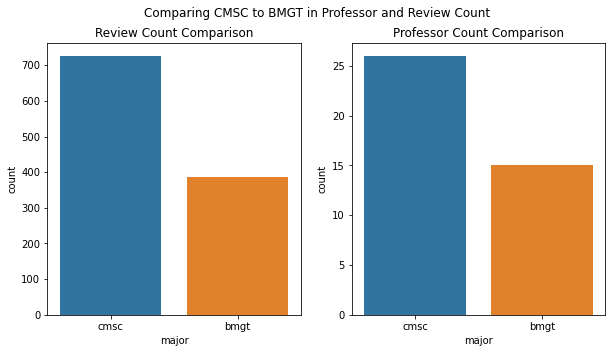

In [114]:
stats_df = pd.DataFrame(columns=['major', 'count'])
stats_df['major'] = ['cmsc', 'bmgt']
stats_df['count'] = [len(all_cmsc_stats), len(all_bmgt_stats)]

reviews_df = pd.DataFrame(columns=['major', 'count'])
reviews_df['major'] = ['cmsc', 'bmgt']
reviews_df['count'] = [len(all_cmsc_reviews), len(all_bmgt_reviews)]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('Comparing CMSC to BMGT in Professor and Review Count')
ax[0].set(title="Review Count Comparison")
ax[1].set(title="Professor Count Comparison")

sns.barplot(x='major', y='count', data=reviews_df, ax=ax[0])
sns.barplot(x='major', y='count', data=stats_df, ax=ax[1])

plt.show()

In [ ]:
grades_df = pd.DataFrame()
grades_df = grades_df.append(all_pt_grades, ignore_index=True)

### Analyzing Word Frequencies and Rudimentary Sentiment Analysis in Reviews

#### Using SpaCy

In [ ]:
##  Need to run python -m spacy download en_core_web_sm (also a medium and large dataset)
nlp = spacy.load('en_core_web_sm')

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
punctuation = string.punctuation

In [ ]:
# Credit to https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
def tokenize_lemmatize_text(text):
    tokens = nlp(text)
    
    tokens = [word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in tokens]
    tokens = [lemma for lemma in tokens if lemma not in spacy_stopwords and lemma not in punctuation]
    
    return tokens

##### Word Frequency

##### Bag of Words maybe for TF-IDF

In [ ]:
vectorizer = CountVectorizer(tokenizer=tokenize_lemmatize_text, ngram_range=(1,1))
X = vectorizer.fit_transform([good_text, bad_text])

### Label the Reviews as Positive or Negative - Rudimentary

TODO: Explain why we did it this way

#### Reading Positive and Negative Lexicons

In [ ]:
def save_word_dict(filepath, word_dict):
    """Saves word frequency dictionaries to a pickle file."""
    pickle.dump(word_dict, open(filepath, 'wb'))
    
def read_word_dict_file(filepath):
    """Reads a word frequency dictionary from a pickle file."""
    return pickle.load(open(filepath, 'rb'))

def read_lexicon(filepath):
    """Read a lexicon full of words from a file and insert them into
    a list to return. Simple \n separation.
    
    Args:
        filepath: A string containing the filepath to the lexicon.
        
    Returns:
        A list of words (one per line).
    """
    
    lexicon = []
    
    with open(filepath, 'r') as fp:
        all_words = fp.readlines()
        for word in all_words:
            lexicon.append(word.strip())
            
    return lexicon

In [ ]:
# Load positive words
positive_words = read_lexicon('./data/lexicon/positive-words.txt')
positive_words.append('funny')
positive_words.remove('tough')

# Load negative words
negative_words = read_lexicon('./data/lexicon/negative-words.txt')
negative_words.append('tough')
negative_words.remove('funny')

#### Functions for Scoring and Labeling the Sentiment of Reviews 

In [ ]:
def save_sentiment_score_labels(review_df, source, major):
    if not should_store_data:
        return
    
    if source == 'pt':
        if major == 'bmgt':
            db_filepath = bmgt_pt_db_filepath
        else:
            db_filepath = cmsc_pt_db_filepath
    else:
        if major == 'bmgt':
            db_filepath = bmgt_rmp_db_filepath
        else:
            db_filepath = cmsc_rmp_db_filepath
            
    db_conn = create_connection(db_filepath)
    
    try:
        insert_all_review_sentiment_labels(db_conn, review_df)
    except Exception as e:
        print("Type error: " + str(e))
        traceback.print_exc()
        
    finally:
        if db_conn:
            db_conn.close()
            
            
def update_word_dict(word_dict, word):
    """Updates a counting dictionary depending on if key is present."""
    if word not in word_dict:
        word_dict[word] = 1
    else:
        word_dict[word] = word_dict[word] + 1
        
    return word_dict

def normalize_score(score, max_score, min_score):
    """Normalizes the score to [-1, 1] range."""
    denom = (max_score - min_score)
    
    if denom == 0:
        return np.nan
    
    norm_score = 2 * ((score - min_score) / denom) - 1
    
    return norm_score

def get_label_from_score(score):
    """Returns a label for a score, where 1 is positive,
    0 is neutral, and -1 is negative."""
    
    if score > 0:
        return 1
    elif score < 0:
        return -1
    
    return score
        
def score_review(review_body, positive_dict, negative_dict, all_word_dict):
    """A rudimentary sentiment scoring algorithm, which subtracts from the
    score when a negative word is present and adds to the score when a 
    positive word is present. No POS is used. Words are lemmatized.
    
    Args:
        review_body: A string containing the body of the review.
        
    Returns:
        An integer score
    """
    
    score = 0
    tokens = tokenize_lemmatize_text(review_body)
    
    for token in tokens:
        all_word_dict = update_word_dict(all_word_dict, token)
        
        if token in positive_words:
            positive_dict = update_word_dict(positive_dict, token)
            score = score + 1
        
        elif token in negative_words:
            negative_dict = update_word_dict(negative_dict, token)
            score = score - 1
            
    return (score, positive_dict, negative_dict, all_word_dict)

def score_all_reviews(review_df):
    """Scores each review as in range [-1, 1], and also keeps
    track of the frequencies of words for all, positive, and negative words.
    
    Args:
        review_df: A dataframe containing reviews.
        
    Returns:
        A tuple of an updates review dataframe with scores, a positive word frequency dictionary,
        a negative word frequency dictionary, and all word dictionary frequency.
    """
    
    scores = []
    positive_dict = {}
    negative_dict = {}
    all_word_dict = {}
    
    for row in review_df.itertuples():
        (score, positive_dict, negative_dict, all_word_dict) = score_review(row.body, positive_dict, negative_dict, all_word_dict)
        scores.append(score)
        
    # TODO: Normalize scores if we want a range of positive/negativeness?
    max_score = max(scores)
    min_score = min(scores)
    norm_scores = [normalize_score(score, max_score, min_score) for score in scores]
    
    # Label the reviews
    labels = [get_label_from_score(score) for score in scores]
    
    review_df['sentiment_score'] = scores
    review_df['sentiment_ground_label'] = labels
    
    return (review_df, positive_dict, negative_dict, all_word_dict)

#### Score and Label CMSC Reviews

In [ ]:
cmsc_dict_fp = './data/word_lists/cmsc_'

cmsc_review_sentiment_df = all_cmsc_reviews.copy()
null_sentiment_labels = cmsc_review_sentiment_df['sentiment_ground_label'].isnull().sum()

if null_sentiment_labels == len(cmsc_review_sentiment_df):
    (cmsc_review_sentiment_df, cmsc_positive_dict, cmsc_negative_dict, cmsc_all_word_dict) = score_all_reviews(cmsc_review_sentiment_df)
    
    cmsc_pt_reviews = cmsc_review_sentiment_df.loc[cmsc_review_sentiment_df['source'] == 'pt']
    save_sentiment_score_labels(cmsc_pt_reviews, 'pt', 'cmsc')
        
    cmsc_rmp_reviews = cmsc_review_sentiment_df.loc[cmsc_review_sentiment_df['source'] == 'rmp']
    save_sentiment_score_labels(cmsc_rmp_reviews, 'rmp', 'cmsc')
    
    save_word_dict(cmsc_dict_fp + 'positive.p', cmsc_positive_dict)
    save_word_dict(cmsc_dict_fp + 'negative.p', cmsc_negative_dict)
    save_word_dict(cmsc_dict_fp + 'all.p', cmsc_all_word_dict)
else:
    cmsc_positive_dict = read_word_dict_file(cmsc_dict_fp + 'positive.p')
    cmsc_negative_dict = read_word_dict_file(cmsc_dict_fp + 'negative.p')
    cmsc_all_word_dict = read_word_dict_file(cmsc_dict_fp + 'all.p')

cmsc_review_sentiment_df.head()

#### Score and Label BMGT Reviews

In [ ]:
bmgt_dict_fp = './data/word_lists/bmgt_'

bmgt_review_sentiment_df = all_bmgt_reviews.copy()
null_sentiment_labels = bmgt_review_sentiment_df['sentiment_ground_label'].isnull().sum()

if null_sentiment_labels == len(bmgt_review_sentiment_df): 
    (bmgt_review_sentiment_df, bmgt_positive_dict, bmgt_negative_dict, bmgt_all_word_dict) = score_all_reviews(bmgt_review_sentiment_df)
    
    bmgt_pt_reviews = bmgt_review_sentiment_df.loc[bmgt_review_sentiment_df['source'] == 'pt']
    save_sentiment_score_labels(bmgt_pt_reviews, 'pt', 'bmgt')
        
    bmgt_rmp_reviews = bmgt_review_sentiment_df.loc[bmgt_review_sentiment_df['source'] == 'rmp']
    save_sentiment_score_labels(bmgt_rmp_reviews, 'rmp', 'bmgt')
    
    save_word_dict(bmgt_dict_fp + 'positive.p', bmgt_positive_dict)
    save_word_dict(bmgt_dict_fp + 'negative.p', bmgt_negative_dict)
    save_word_dict(bmgt_dict_fp + 'all.p', bmgt_all_word_dict)
else:
    bmgt_positive_dict = read_word_dict_file(bmgt_dict_fp + 'positive.p')
    bmgt_negative_dict = read_word_dict_file(bmgt_dict_fp + 'negative.p')
    bmgt_all_word_dict = read_word_dict_file(bmgt_dict_fp + 'all.p')
    

bmgt_review_sentiment_df.head()

### Looking at how often these types of words are used per major

In [ ]:
cmsc_all_word_count = sum(cmsc_all_word_dict.values())
cmsc_positive_pct = sum(cmsc_positive_dict.values()) / cmsc_all_word_count
cmsc_negative_pct = sum(cmsc_negative_dict.values()) / cmsc_all_word_count

bmgt_all_word_count = sum(bmgt_all_word_dict.values())
bmgt_positive_pct = sum(bmgt_positive_dict.values()) / bmgt_all_word_count
bmgt_negative_pct = sum(bmgt_negative_dict.values()) / bmgt_all_word_count

word_pct_df = pd.DataFrame(columns=['type', 'major', 'percentage'])

word_pct_df = word_pct_df.append({'type': 'positive' , 'major': 'bmgt', 'percentage': bmgt_positive_pct}, ignore_index=True)
word_pct_df = word_pct_df.append({'type': 'negative' , 'major': 'bmgt', 'percentage': bmgt_negative_pct}, ignore_index=True)


word_pct_df = word_pct_df.append({'type': 'positive' , 'major': 'cmsc', 'percentage': cmsc_positive_pct}, ignore_index=True)
word_pct_df = word_pct_df.append({'type': 'negative' , 'major': 'cmsc', 'percentage': cmsc_negative_pct}, ignore_index=True)


ax = sns.catplot(x='type', y='percentage', kind='bar', hue='major', data=word_pct_df)
ax.set(xlabel='Type of words', ylabel='Perctange of all words', title='Percentage of types of words per major')

### Analyzing Review Trends

## Visualization

TODO: Describe section

### Visualizing Word Associations and Sentiments

In [ ]:
def create_wordcloud(word_freq_dict):
    """Creates a single WordCloud given the word frequency dictionary.
    
    Args:
        word_freq_dict: A dictionary of word frequencies.
        
    Returns:
        A WordCloud object created from the provided dictionary.
    """
    
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate_from_frequencies(word_freq_dict)
    
    return wc
    
def plot_multiple_wordclouds(titles, word_freq_dicts):
    """Creates a wordcloud for each word frequency dictionary into a 
    3 x 1 subplot figure. Titles must be the same length as the dictionaries.
    
    Args:
        titles: Title of each plot/word cloud.
        word_freq_dicts: List of word frequency dictionaries.
    """
    
    figure, ax = plt.subplots(1, 3, figsize=(30, 10))
    
    for idx in range(len(word_freq_dicts)):
        ax[idx].imshow(create_wordcloud(word_freq_dicts[idx]))
        ax[idx].axis('off')
        ax[idx].set_title(titles[idx], fontdict={'fontsize': 23})
            
    plt.show()

In [ ]:
plot_multiple_wordclouds(['Positive', 'Negative', 'All'], [cmsc_positive_dict, cmsc_negative_dict, cmsc_all_word_dict])

In [ ]:
plot_multiple_wordclouds(['Positive', 'Negative', 'All'], [bmgt_positive_dict, bmgt_negative_dict, bmgt_all_word_dict])

### Visualizing Review Trends and Trends Over Time

## Insights and Conclusion

It is worthy to consider possible sources of bias inside our data set. One bias at play is negativity bias -- the bias that people who have had negative experiences are more likely to respond on surveys or polls. In the case of RateMyProfessor, this is almost certainly influential -- students who received their first bad grade, or first conflict with a professor, are more likely to express and vent their frustration than students who have had relatively plain or positive experiences. Furthermore, the aggregate of all reviews from each major yielded about 2x more CS students than BMGT students (726 CS to 387 BMGT) -- for one reason or another, CS students are more represented on these online websites. Although we normalized for these (accounting for percentages of reviews positive/negative, rather than frequencies), the sample size may not be perfectly representative of the population as a whole. 

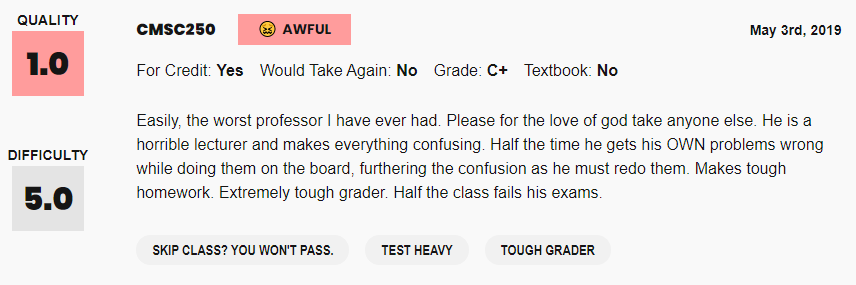

In [3]:
from IPython.display import Image
Image("img/angry_review.png")

## Potential Future Work